In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load the Fashion MNIST dataset

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [3]:
print(train_images[0].shape) # 각 이미지는 (28, 28)의 차원을 가짐
print(np.min(train_images), np.max(train_images)) # 픽셀값은 0 ~ 255 값을 가짐

(28, 28)
0 255


In [4]:
class_name = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
    ]

### Preprocess the date

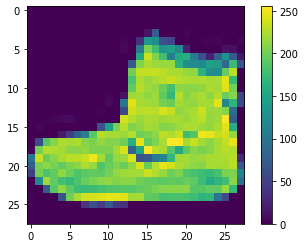

In [5]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

- 픽셀값이 `0 ~ 255` 범위이므로 255로 나눠 `0 ~ 1` 의 범위로 정규화를 시켜준다.

In [6]:
train_images = train_images / 255.
test_images = test_images / 255.

print(np.min(train_images), np.max(train_images))

0.0 1.0


- 데이터가 올바르게 정규화가 되었는지 시각화하여 확인

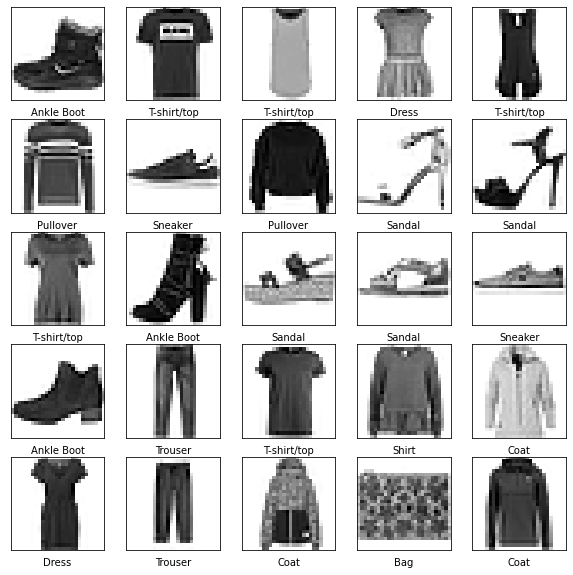

In [7]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_name[train_labels[i]])
plt.show()

In [8]:
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

In [9]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(len(train_images)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

### Build Model

In [10]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dense2 = tf.keras.layers.Dense(10)
        
    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [11]:
model = MyModel()

In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [13]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')

In [14]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_acc(labels, predictions)

In [15]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_object(labels, predictions)
    
    test_loss(loss)
    test_acc(labels, predictions)

'Test Accuracy'가 'Train Accuracy'보다 약간 낮게 나왔다. 이 차이는 *과적합(overfitting)*을 나타낸다.
- '과적합'은 모델이 새로운 데이터에 대한 예측을 할 때 좋지 않은 성능을 보일 때 발생한다.
- '과적합'을 해결하는 가장 간단한 방법은 **모델의 크기를 줄이는 것**이다.

In [16]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss.reset_state()
    train_acc.reset_state()
    test_loss.reset_state()
    test_acc.reset_state()
    
    for images, labels in train_ds:
        train_step(images, labels)
        
    for images, labels in test_ds:
        test_step(images, labels)
        
    print(
        f'Epoch: {epoch + 1}, ',
        f'Train Loss: {train_loss.result()}, ',
        f'Train Accuracy: {train_acc.result() * 100}, ',
        f'Test Loss: {test_loss.result()}, ',
        f'Test Accuracy: {test_acc.result() * 100}'
    )

Epoch: 1,  Train Loss: 0.49967485666275024,  Train Accuracy: 82.53333282470703,  Test Loss: 0.43779173493385315,  Test Accuracy: 84.19000244140625
Epoch: 2,  Train Loss: 0.3798903226852417,  Train Accuracy: 86.24333190917969,  Test Loss: 0.42284995317459106,  Test Accuracy: 84.38999938964844
Epoch: 3,  Train Loss: 0.3404775857925415,  Train Accuracy: 87.5183334350586,  Test Loss: 0.3694193661212921,  Test Accuracy: 86.79999542236328
Epoch: 4,  Train Loss: 0.31517112255096436,  Train Accuracy: 88.41166687011719,  Test Loss: 0.3600849509239197,  Test Accuracy: 87.06999969482422
Epoch: 5,  Train Loss: 0.3005656599998474,  Train Accuracy: 88.85166931152344,  Test Loss: 0.3727708160877228,  Test Accuracy: 86.47999572753906
Epoch: 6,  Train Loss: 0.2825305461883545,  Train Accuracy: 89.52833557128906,  Test Loss: 0.34124523401260376,  Test Accuracy: 87.6500015258789
Epoch: 7,  Train Loss: 0.27080440521240234,  Train Accuracy: 89.94000244140625,  Test Loss: 0.34142789244651794,  Test Accuracy

### Make predictions

- `softmax` 레이어를 연결하여 모델의 선형 출력(logits)을 해석하기 쉬운 확률로 변환한다.

In [17]:
probability_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

In [18]:
predictions = probability_model.predict(test_images)
predictions[111]

313/313 [==============================] - 1s 2ms/step


array([3.3970599e-07, 1.3152038e-15, 7.7680902e-09, 1.1165472e-13,
       6.3552887e-09, 9.9999726e-01, 7.4425386e-09, 2.3831255e-06,
       7.6508373e-09, 1.4135192e-10], dtype=float32)

- 모델이 가장 '확신'을 가지고 있는 label 출력

In [19]:
np.argmax(predictions[111])

5

- 모델은 '5'를 예측했고, 실제값인 test_labels의 값과 일치하는 것을 확인

In [20]:
test_labels[111]

5

### Results visualization

In [21]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(
        class_name[predicted_label],
        np.max(predictions_array) * 100,
        class_name[true_label],
        color=color))
    
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

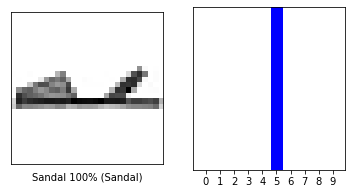

In [22]:
i = 111
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

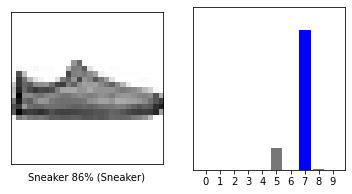

In [23]:
i = 12
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

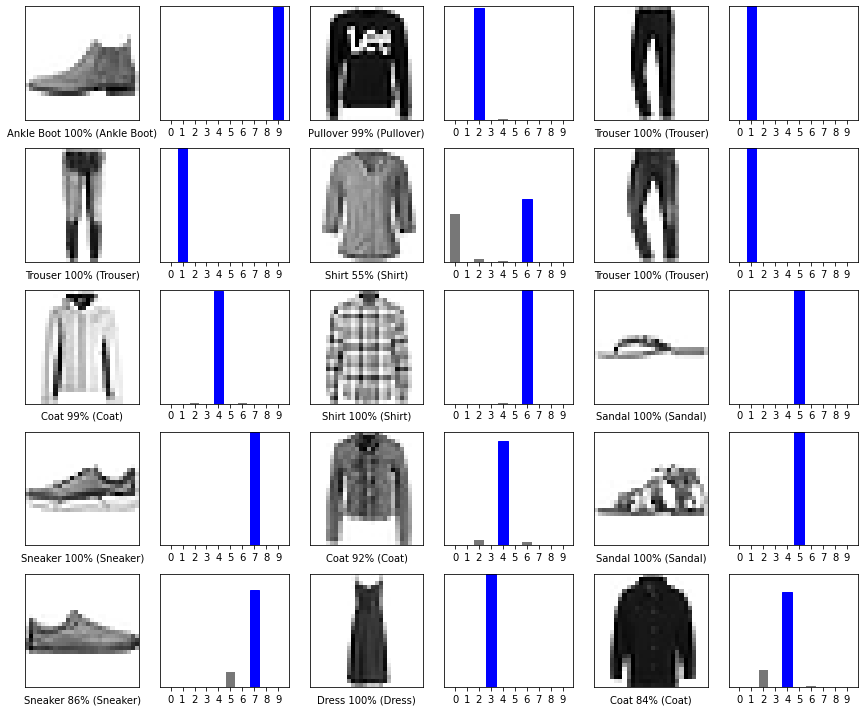

In [24]:
rows = 5
columns = 3
n_images = rows * columns

plt.figure(figsize=(2*2*columns, 2*rows))
for i in range(n_images):
    plt.subplot(rows, 2*columns, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(rows, 2*columns, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

### Use the trained model

In [25]:
img = test_images[777]
print(img.shape)

(28, 28)


- 'keras' 모델은 데이터들에 대한 예측을 일괄적으로 수행하도록 최적화되어 있다. 따라서 단일 이미지를 예측하더라도 목록에 추가해야 한다.

In [26]:
img = (np.expand_dims(img, 0))
print(img.shape)

(1, 28, 28)


In [27]:
prediction_single = probability_model.predict(img)
print(prediction_single)

1/1 [==============================] - 0s 20ms/step
[[1.1301024e-06 9.9998641e-01 3.2664352e-06 4.4110566e-06 4.8389643e-06
  2.6514764e-11 6.3177694e-08 1.0055719e-14 3.1005154e-08 5.1792726e-11]]


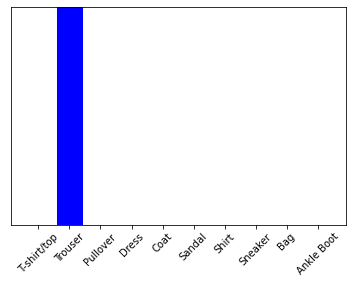

In [28]:
plot_value_array(777, prediction_single[0], test_labels)
_ = plt.xticks(range(10), class_name, rotation=45)
plt.show()

In [29]:
np.argmax(prediction_single[0])

1